In [1]:
%matplotlib inline
import sys, platform, os
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
import camb
from camb import model, initialpower
from scipy import integrate
from numpy import loadtxt
import copy
import math

plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams.update({'font.size': 11})

#### Load redshift bins and galaxy density n(z) for spectroscopic and photometric samples

https://arxiv.org/pdf/1308.4164.pdf

In [2]:
f=open('n_z.txt',"r")
lines=f.readlines()
zspec_tmp=[];nspec_tmp=[]
for x in lines:
    zspec_tmp.append(float(x.split(None)[0]))
    nspec_tmp.append(float(x.split(None)[1]))
f.close()

f=open('redshifts_phot.txt',"r")
lines=f.readlines()
z_phot=[]; z_min=[]; z_max=[]; nphot_tmp=[]
for x in lines:
    z_min.append(float(x.split(None)[0]))
    z_phot.append(float(x.split(None)[1]))
    z_max.append(float(x.split(None)[2]))
    nphot_tmp.append(float(x.split(None)[3]))
f.close()

zspec_tmp=np.array(zspec_tmp)
nspec_tmp=np.array(nspec_tmp)*((0.675)**3.)
z_phot=np.array(z_phot)
nphot_tmp=np.array(nphot_tmp)

### Set fiducial cosmology

In [3]:
fid_params={'h':[0.675], 'Omb':[0.048], 'Omc':[0.268], 'ns':[0.965], 'As':[2e-09], 'w':[-1.0]}
print 'Fiducial Parameters:', fid_params

#List of fiducial parameters:
params_f=[p[0] for p in fid_params.itervalues()]

n_pts=50
f_sky=0.048

Fiducial Parameters: {'Omc': [0.268], 'Omb': [0.048], 'h': [0.675], 'As': [2e-09], 'w': [-1.0], 'ns': [0.965]}


### Specify parameters to vary and step size

In [4]:
step_dict={'Omb':[0.002], 'Omc':[0.003], 'ns':[0.01], 'As':[5e-11], 'w':[0.03]}
#step_dict={'Omc':[0.003], 'w':[0.03]}

print 'Parameters to vary and step size:',step_dict

Parameters to vary and step size: {'Omc': [0.003], 'Omb': [0.002], 'As': [5e-11], 'ns': [0.01], 'w': [0.03]}


In [5]:
def list_params(Step_dict, Fid_params):
    step_keys=[key for key in Step_dict.iterkeys()]
    keys=[p for p in Fid_params.iterkeys()]

    Params=copy.deepcopy(Fid_params)

    for i in keys:
        if i in step_keys:
            Params[i].append(Fid_params[i][0]+Step_dict[i][0])
            Params[i].append(Fid_params[i][0]-Step_dict[i][0])
        Params[i].sort()
    return [Params[i] for i in keys], keys, step_keys

params_list, keys, step_keys=list_params(step_dict, fid_params)
print 'Cosmological parameters that will be used:', params_list

Cosmological parameters that will be used: [[0.265, 0.268, 0.271], [0.046, 0.048, 0.05], [0.675], [1.95e-09, 2e-09, 2.05e-09], [-1.03, -1.0, -0.97], [0.955, 0.965, 0.975]]


### Calculate matter power spectrum for various cosmologies

In [6]:
def Power_spectrum(param, Z_bin, K_max):
    Omc, Omb, h, A_s, w, n_s = param
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=100.*h, ombh2=Omb*(h**2), omch2=Omc*(h**2.), omk=0)
    pars.set_dark_energy(w)
    pars.InitPower.set_params(As= A_s, ns=n_s)
    pars.set_matter_power(redshifts=Z_bin, kmax=2.0)

    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    kh, z, pk = results.get_matter_power_spectrum(minkh=1e-3, maxkh=K_max, npoints = n_pts)
    t = results.get_matter_transfer_data()
    
    qt=t.transfer_data[0, :, 0]
    transf=[]
    for i in range(len(Z_bin)):
        transf_interp=interp1d(qt, t.transfer_data[6, :, i])
        transf.append(transf_interp(kh))
    
    if param==params_f:
        res_fid = camb.get_results(pars)
        t_fid = res_fid.get_matter_transfer_data()

        qt_fid=t_fid.transfer_data[0, :, 0]
        transf_fid=[]
        for i in range(len(Z_bin)):
            interp_fid=interp1d(qt_fid, t_fid.transfer_data[6, :, i])
            transf_fid.append(interp_fid(kh)) 
            
        pars.set_matter_power(redshifts=[0.0], kmax=2.0)
        pars.NonLinear = model.NonLinear_none
        results2 = camb.get_results(pars)
        s8=results2.get_sigma8()        
        return kh, pk, res_fid, np.array(transf_fid)[::-1,:], s8
    
    pars.set_matter_power(redshifts=[0.0], kmax=2.0)
    pars.NonLinear = model.NonLinear_none
    results2 = camb.get_results(pars)
    s8=results2.get_sigma8()
    return kh, pk, np.array(transf)[::-1,:], s8

def calculate_PS(Params_list, Params_f, n_params, print_steps, Z_bin, K_max):
    PS=np.zeros((2*n_params,len(Z_bin), n_pts))
    transf=np.zeros((2*n_params,len(Z_bin), n_pts))
    Omega_m=[]; W=[]; sig8=[]

    l=0; vary=[]
    for i in range(len(Params_list)):
        for j in range(len(Params_list[i])):
            if len(Params_list[i])>1:
                par=list(Params_f)
                par[i]=Params_list[i][j]
                if par!=Params_f:
                    vary.append(Params_list[i][j])
                    k, PS[l], transf[l], S8 =Power_spectrum(par, Z_bin, K_max)
                    sig8.append(S8)

                    l+=1
                    if print_steps:
                        print 'Parameters: (%s,%s)'%(i, j), par
                    Omega_m.append(par[0]+par[1])
                    W.append(par[4])
    return k, PS, transf, vary, Omega_m, W, sig8

k, PS, Transf, vary, omg_m, w, sigma8=calculate_PS(params_list, params_f, len(step_dict), True, z_phot, 0.2)

Note: redshifts have been re-sorted (earliest first)
Parameters: (0,0) [0.265, 0.048, 0.675, 2e-09, -1.0, 0.965]
Note: redshifts have been re-sorted (earliest first)
Parameters: (0,2) [0.271, 0.048, 0.675, 2e-09, -1.0, 0.965]
Note: redshifts have been re-sorted (earliest first)
Parameters: (1,0) [0.268, 0.046, 0.675, 2e-09, -1.0, 0.965]
Note: redshifts have been re-sorted (earliest first)
Parameters: (1,2) [0.268, 0.05, 0.675, 2e-09, -1.0, 0.965]
Note: redshifts have been re-sorted (earliest first)
Parameters: (3,0) [0.268, 0.048, 0.675, 1.95e-09, -1.0, 0.965]
Note: redshifts have been re-sorted (earliest first)


Parameters: (3,2) [0.268, 0.048, 0.675, 2.05e-09, -1.0, 0.965]
Note: redshifts have been re-sorted (earliest first)


Parameters: (4,0) [0.268, 0.048, 0.675, 2e-09, -1.03, 0.965]
Note: redshifts have been re-sorted (earliest first)
Parameters: (4,2) [0.268, 0.048, 0.675, 2e-09, -0.97, 0.965]
Note: redshifts have been re-sorted (earliest first)
Parameters: (5,0) [0.268, 0.048, 0.675, 2e-09, -1.0, 0.955]
Note: redshifts have been re-sorted (earliest first)
Parameters: (5,2) [0.268, 0.048, 0.675, 2e-09, -1.0, 0.975]


### Fiducial Case

In [7]:
k, PS_fid, res_fid, Transf_fid, s8_fid=Power_spectrum(params_f, z_phot, 0.2)
H_bar = np.array([res_fid.h_of_z(i) for i in z_phot])
r_z=np.array([res_fid.comoving_radial_distance(i) for i in z_phot])
c=299792.
print 'H(z)=', H_bar*c

Note: redshifts have been re-sorted (earliest first)
H(z)= [  71.8840287    82.72594443   96.16201412  111.84406116  129.46283182
  148.77136065  169.57947346  191.74129114  215.14363315  239.69710357
  265.32967115  291.98214066  319.60496132  348.15595847  377.59870005
  407.90130216  439.03554173  470.97618679  503.70048313  537.18775496]


### Normalizing photometric n(z) (again...)

In [8]:
def integ_z(z):
    return (((res_fid.comoving_radial_distance(z))**2.)/(res_fid.h_of_z(z)))

vol=[]
for i in range(len(z_phot)):
    integ=integrate.quad(integ_z, z_min[i], z_max[i])
    vol.append(4.*np.pi*f_sky*(integ[0]/((0.675)**3.)))
    
nphot_tmp2=(nphot_tmp/vol)

nphot_tmp3=[]
for i in range(len(z_phot)):
    integ=integrate.quad(integ_z, z_min[i], z_max[i])
    nphot_tmp3.append(integ[0]*nphot_tmp2[i])
norm =sum(nphot_tmp3)/(45.*((10800./np.pi)**2.))
n_phot=np.array(nphot_tmp2)/(norm)

In [9]:
ngal_spec=[]
for i in range(len(zspec_tmp)-1):
    ngal_spec.append(4.*np.pi*f_sky*(nspec_tmp[i]/((0.675)**3.))*(integrate.quad(integ_z, zspec_tmp[i], zspec_tmp[i+1])[0]))
    
print 'Total number of photometric galaxies = ', sum(4.*np.pi*f_sky*(np.array(nphot_tmp3)/norm))/(10**6.), '10^6'
print 'Total number of spectroscopic galaxies = ', sum(ngal_spec)/(10**6.), '10^6'

Total number of photometric galaxies =  320.783026675 10^6
Total number of spectroscopic galaxies =  24.8711150276 10^6


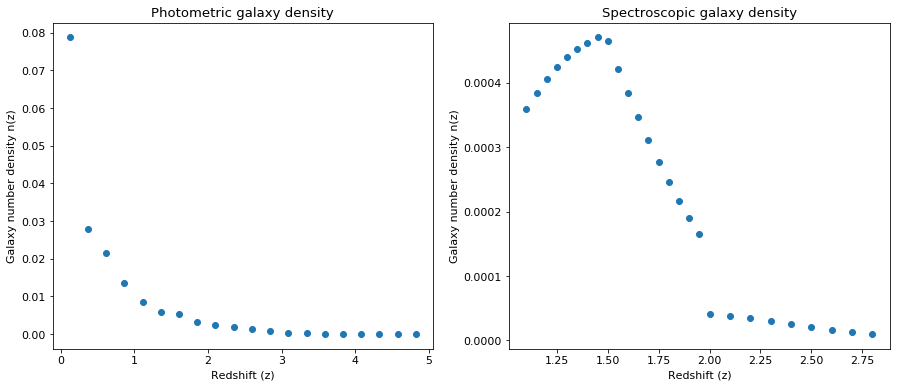

In [10]:
plt.rcParams['figure.figsize'] = (15, 6)

plt.subplot(121)
plt.plot(z_phot, n_phot,'o')
plt.xlabel('Redshift (z)')
plt.ylabel('Galaxy number density n(z)')
plt.title('Photometric galaxy density')

plt.subplot(122)
plt.plot(zspec_tmp, nspec_tmp, 'o')
plt.xlabel('Redshift (z)')
plt.ylabel('Galaxy number density n(z)')
plt.title('Spectroscopic galaxy density')

plt.show()

Setting the spectroscopic bins equal to the photometric bins:

In [11]:
z_spec=[]; n_spec=[]
for i in range(len(z_phot)):
    mask=(zspec_tmp>z_min[i])*(zspec_tmp<z_max[i])
    z_new=zspec_tmp[mask]
    if len(z_new)>0:
        mean_z=np.mean(z_new)
        z_spec.append(z_phot[min(range(len(z_phot)), key=lambda i: abs(z_phot[i]-mean_z))])
        sum_n=sum(nspec_tmp[mask])
        n_spec.append(sum_n)
        
cont=0
for i in range(len(z_phot)):
    if z_phot[i] not in z_spec and cont==0:
        n_spec=[1e-9] + n_spec
    if z_phot[i] in z_spec:
        cont=1
    if z_phot[i] not in z_spec and cont==1:
        n_spec=n_spec + [1e-9]

In [12]:
zspec_min=zspec_tmp-((zspec_tmp[1]-zspec_tmp[0])/2.)
zspec_max=zspec_tmp+((zspec_tmp[1]-zspec_tmp[0])/2.)
z_spec=[]; n_spec=[]

for i in range(len(z_phot)):
    mask=(zspec_tmp>z_min[i])*(zspec_tmp<z_max[i])
    z_new=zspec_tmp[mask]
    if len(z_new)>0:
        mean_z=np.mean(z_new)
        z_spec.append(z_phot[min(range(len(z_phot)), key=lambda i: abs(z_phot[i]-mean_z))])
        vol=[]; n=[]
        for j in range(len(z_new)):
            ind=list(zspec_tmp).index(z_new[j])
            vol.append(integrate.quad(integ_z, zspec_min[ind], zspec_max[ind])[0])
            n.append(nspec_tmp[ind]*vol[j])
        n_spec.append(sum(n)/sum(vol))
        
cont=0
for i in range(len(z_phot)):
    if z_phot[i] not in z_spec and cont==0:
        n_spec=[1e-7] + n_spec
    if z_phot[i] in z_spec:
        cont=1
    if z_phot[i] not in z_spec and cont==1:
        n_spec=n_spec + [1e-7]

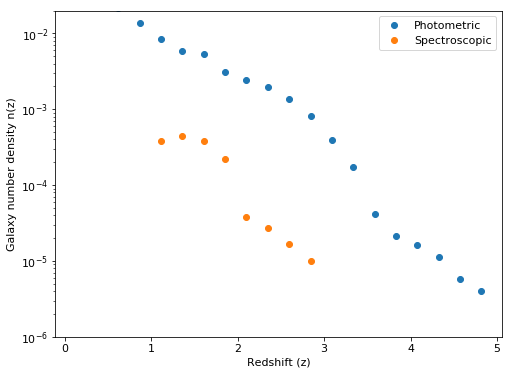

In [13]:
plt.rcParams['figure.figsize'] = (8, 6)

plt.plot(z_phot, n_phot,'o', label='Photometric')
plt.plot(z_phot, n_spec,'o', label='Spectroscopic')
plt.yscale('log')
plt.legend(loc='best')
plt.xlabel('Redshift (z)')
plt.ylabel('Galaxy number density n(z)')
plt.ylim(10**(-6.), 2.*10**(-2))
plt.show()

In [14]:
def angle(a,b,c):
    return math.acos(-(a**2. + b**2. -(c**2.))/(2.*a*b))

def F_2(a,b,c):
    cos=-(a**2. + b**2. -(c**2.))/(2.*a*b)
    return 5./7. + ((a*b*cos)/(2.*a*b))*((a/b) + (b/a)) + (2./7.)*(((a*b*cos)/(a*b)))**2.

def exp_z(K, Mu, Sigma_z, H):
    return (np.exp(-(((K)**2.)*((Mu)**2.)*((Sigma_z)**2.))/(2.*(H**2.))))

In [15]:
k0, PS_fid0, _, _, _=Power_spectrum(params_f, [0.0], 0.8)

fid_interp = interp1d(k0, PS_fid0, kind='cubic')

theta=np.linspace(0,np.pi, 50)
mu=np.cos(theta)
sig_z=np.array(0.04*(1.+z_phot))

In [16]:
def Bispectrum(K1, K2, Mu, Sigma_z):
    K3=np.linspace((K1-K2), K1+K2 , 200)
    #Q_ssp=np.zeros((len(K3)))
    B_ssp=np.zeros((len(K3), len(mu)))
    B_sss=np.zeros((len(K3)))

    for l in range(len(K3)):
        B_sss[l]=(2.*F_2(K1, K2, K3[l])*fid_interp(K1)*fid_interp(K2) 
                  + 2.*F_2(K2, K3[l], K1)*fid_interp(K2)*fid_interp(K3[l]) 
                  + 2.*F_2(K3[l], K1, K2)*fid_interp(K3[l])*fid_interp(K1))
        for m in range(len(mu)):
            B_ssp[l][m]=exp_z(K3[l], Mu[m], Sigma_z, 67.5/c)*(2.*F_2(K1, K2, K3[l])*fid_interp(K1)*fid_interp(K2) 
                       + 2.*F_2(K2, K3[l], K1)*fid_interp(K2)*fid_interp(K3[l]) 
                       + 2.*F_2(K3[l], K1, K2)*fid_interp(K3[l])*fid_interp(K1))
        #Q_test[l]=B_test[l]/(fid_interp(K1)*fid_interp(K2) + fid_interp(K2)*fid_interp(K3[l]) 
        #                    + fid_interp(K1)*fid_interp(K3[l]))
        
    return B_ssp, B_sss

Bssp, Bsss=Bispectrum(0.04, 0.039, mu, 0.005)
Bssp2, _=Bispectrum(0.04, 0.039, mu, 0.006)

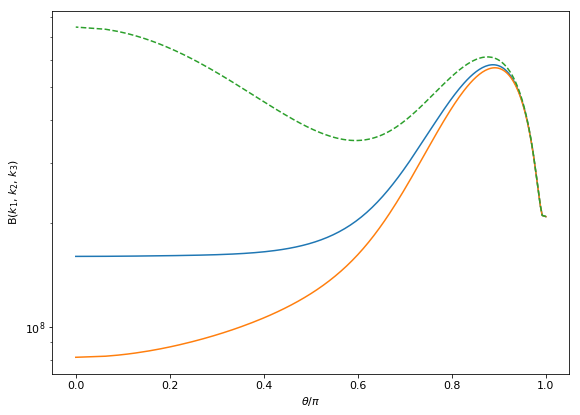

In [17]:
k3=np.linspace((0.04-0.039), 0.04+0.039 , 200)
ang2=[angle(0.04,0.039,i)/np.pi for i in k3]
plt.plot(ang2, Bssp[:,0])
plt.plot(ang2, Bssp2[:,0])
plt.plot(ang2, Bsss,'--')
plt.xlabel(r'$\theta / \pi$')
plt.ylabel(r'B($k_1$, $k_2$, $k_3$)')
plt.tight_layout()
plt.yscale('log')
#plt.savefig('reduced.pdf')
#plt.ylim(10**(7), 10**9)
plt.show()

In [47]:
PS3=np.zeros((2*len(step_dict),len(z_phot), n_pts))
for i in range(len(PS)):
        PS3[i]=(PS[i])*((s8_fid/sigma8[i])**2.)

In [18]:
PS2=np.zeros((2*len(step_dict),len(z_phot), n_pts))
for i in range(len(PS)):
        PS2[i]=(PS[i])*((s8_fid/sigma8[i])**2.)
        
PS2[4]=(PS_fid[:,:])*(((s8_fid - s8_fid*0.01)/sigma8[4])**2.)
PS2[5]=(PS_fid[:,:])*(((s8_fid + s8_fid*0.01)/sigma8[5])**2.)

In [19]:
vary[4]=s8_fid - s8_fid*0.01
vary[5]=s8_fid + s8_fid*0.01

In [20]:
def Bispectrum_ssp(a,b,c, P_a, P_b, P_c, Mu, Sigma_z, H_z, Vary):
    Sz=np.outer(np.ones((len(Vary))), Sigma_z)
    Hz=np.outer(np.ones((len(Vary))), H_z)
    B_pss=(np.exp(-(((a)**2.)*((Mu)**2.)*((Sz)**2.))/(2.*((Hz)**2.))))*(2.*F_2(a,b,c)*P_a*P_b 
                                            + 2.*F_2(b,c,a)*P_b*P_c + 2.*F_2(c,a,b)*P_c*P_a)
    return B_pss

def Derivative(Vary, Bisp, Z_bin):
    dBisp = np.zeros((len(Vary)/2, len(Z_bin)))
    for i in range(len(Vary)/2):
        for j in range(len(Z_bin)):
            dBisp[i][j]=(Bisp[2*i+1][j]-Bisp[2*i][j])/(Vary[2*i+1]-Vary[2*i])
    return dBisp

In [21]:
def E(A, omg_m, omg_de, w):
    return np.sqrt((omg_m/(A**3.) + omg_de/(A**(3.*(1.+w)))))

def growth1(A, omg_m, omg_de, w):
    a2=np.linspace(10**(-7), A, 200)
    e=np.array([E(i, omg_m, omg_de, w) for i in a2])
    return 2.5*omg_m*E(A, omg_m, omg_de, w)*integrate.simps((a2*e)**(-3.), a2)

def M(K, T, D, Omg_m):
    return -(3./5.)*(((K**2.)*T*D)/(Omg_m*((100./c)**2.)))

f_nl=[0.8- 0.8*1., 0.8 +0.8*1.]

D_z=np.zeros((len(vary), len(z_phot)))
D_fid=[growth1(i, 0.316 , (1.-0.316), -1.) for i in (1./(1.+z_phot))]

for i in range(len(vary)):
    for j in range(len(z_phot)):
        a=1./(1.+z_phot[j])
        D_z[i][j]=growth1(a, omg_m[i], (1.-omg_m[i]), w[i])

Transf_norm=np.zeros(Transf.shape)
Tfid_norm=np.array([Transf_fid[i,:]/Transf_fid[i,0] for i in range(len(z_phot))])

for i in range(len(Transf)):
    for j in range(len(Transf[i])):
        Transf_norm[i][j]=Transf[i,j,:]/Transf[i,j,0]

## Photometric and Spectroscopic Fisher matrix

In [22]:
def exp_z2(K, Mu, Sigma_z, H):
    Mu2=np.outer(Mu, np.ones((len(H))))
    return (np.exp(-(((K)**2.)*((Mu2)**2.)*((Sigma_z)**2.))/(2.*(H**2.))))

In [33]:
def B_total(a,b,c, P_a, P_b, P_c, M_a, M_b, M_c, F_nl):
    B_G=(2.*F_2(a,b,c)*P_a*P_b + 2.*F_2(b,c,a)*P_b*P_c + 2.*F_2(c,a,b)*P_c*P_a)
    B_L=(2.*F_nl*((1./M_a)*(1./M_b)*M_c*P_a*P_b + (1./M_b)*(1./M_c)*M_a*P_b*P_c + (1./M_a)*(1./M_c)*M_b*P_a*P_c))
    B_sss=(B_G + B_L)
    return B_sss

def Fisher_sp(K, Mu, P, P_fid, Rz, F_sky, redshift, Hz, Nz_spec, Nz_phot, Vary, Sigma_z, which, Omg_m, F_nl):
    Omg_m2=np.outer(Omg_m, np.ones((len(redshift))))

    F=np.zeros((len(Vary)/2 +1, len(Vary)/2 +1))
    for p in range(len(Vary)/2 +1):
        for q in range(p,len(Vary)/2 +1):
            integrand3=[]
            for i in range(len(K)):
                integrand2=[]
                k2=[]
                for j in range(i,len(K)):
                    k2.append(K[j])
                    integrand1=[]
                    k1=[]
                    for l in range(j,len(K)):
                        k_lim=min((K[i]+K[j]), max(K))
                        if K[l]<=k_lim:
                            k1.append(K[l])
                            integrand_z=[]
                            integrand_mu=[]
                            
                            B_tot=np.array(B_total(K[i],K[j],K[l], P[:,:,i], P[:,:,j], P[:,:,l], M(K[i], Transf_norm[:,:,i], D_z[:,:], Omg_m2[:,:]), M(K[j], Transf_norm[:,:,j], D_z[:,:], Omg_m2[:,:]), M(K[l], Transf_norm[:,:,l], D_z[:,:], Omg_m2[:,:]), 0.8))
                            B_tot=np.vstack((B_tot, (B_total(K[i],K[j],K[l], P_fid[:,i], P_fid[:,j], P_fid[:,l], M(K[i], Tfid_norm[:,i], D_fid[:], 0.316) , M(K[j], Tfid_norm[:,j], D_fid[:], 0.316), M(K[l], Tfid_norm[:,l], D_fid[:], 0.316), F_nl[0]).reshape((1, len(redshift))))))
                            B_tot=np.vstack((B_tot, (B_total(K[i],K[j],K[l], P_fid[:,i], P_fid[:,j], P_fid[:,l], M(K[i], Tfid_norm[:,i], D_fid[:], 0.316) , M(K[j], Tfid_norm[:,j], D_fid[:], 0.316), M(K[l], Tfid_norm[:,l], D_fid[:], 0.316), F_nl[1]).reshape((1, len(redshift))))))
                            print np.outer(np.ones((len(Mu))), B_tot).shape
                            break
                            
                            deriv_sss=Derivative(np.concatenate((Vary, F_nl)), B_tot, redshift)
                            deriv_ssp=Derivative(np.concatenate((Vary, F_nl)), B_tot*(exp_z(K[i], Mu, Sigma_z, Hz)), redshift)
                            integ=[]
                            if which==0:
                                integ.append(F_sky*((Rz**2.)/Hz)*deriv_sss[p]*deriv_sss[q]*((K[i]*K[j]*K[l])/(4.*(np.pi**3.)*(P_fid[:,i]+(1./Nz_spec))*(P_fid[:,j]+(1./Nz_spec))*(P_fid[:,l]+(1./Nz_spec)))))
                                integ=np.array(integ).reshape((1,len(redshift)))
                            if which==1:
                                integ.append(F_sky*((Rz**2.)/Hz)*deriv_ssp[p]*deriv_ssp[q]*((K[i]*K[j]*K[l])/(4.*(np.pi**3.)*((P_fid[:,i]*(exp_z(K[i], Mu[m], Sigma_z, Hz)**2.))+(1./Nz_phot))*(P_fid[:,j]+(1./Nz_spec))*(P_fid[:,l]+(1./Nz_spec)))))
                                integ=np.array(integ).reshape((1,len(redshift)))
                            if which==2:
                                integ.append(F_sky*((Rz**2.)/Hz)*deriv_sss[p]*deriv_sss[q]*((K[i]*K[j]*K[l])/(4.*(np.pi**3.)*(P_fid[:,i]+(1./Nz_spec))*(P_fid[:,j]+(1./Nz_spec))*(P_fid[:,l]+(1./Nz_spec)))))
                                integ.append(2.*(F_sky*((Rz**2.)/Hz)*deriv_sss[p]*deriv_ssp[q]*((K[i]*K[j]*K[l])/(4.*(np.pi**3.)*((P_fid[:,i]*(exp_z(K[i], Mu[m], Sigma_z, Hz))))*(P_fid[:,j]+(1./Nz_spec))*(P_fid[:,l]+(1./Nz_spec))))))
                                integ.append(F_sky*((Rz**2.)/Hz)*deriv_ssp[p]*deriv_ssp[q]*((K[i]*K[j]*K[l])/(4.*(np.pi**3.)*((P_fid[:,i]*(exp_z(K[i], Mu[m], Sigma_z, Hz)**2.))+(1./Nz_phot))*(P_fid[:,j]+(1./Nz_spec))*(P_fid[:,l]+(1./Nz_spec)))))
                            integrand_z = np.sum(integ, axis=0)
                            integrand_mu.append(integrate.simps(integrand_z, redshift))
                            integrand1.append(integrate.simps(-np.array(integrand_mu), Mu))
                    integrand2.append(integrate.simps(integrand1, k1))
                integrand3.append(integrate.simps(integrand2, k2))
            F[p][q]=integrate.simps(integrand3, K)
            F[q][p]=F[p][q]
            print F
    return F

F_ssp=Fisher_sp(k, mu, PS2, PS_fid, r_z, f_sky, z_phot, H_bar, np.array(n_spec), np.array(n_phot), vary, sig_z, 2, omg_m, f_nl)

(50, 240)


ValueError: If given, length of x along axis must be the same as y.

In [41]:
print np.sqrt(np.linalg.inv(F_ssp))

[[  9.27127817e-03              nan              nan   1.10420901e-02
               nan              nan]
 [             nan   2.02510720e-03   3.74402150e-03              nan
    5.07427152e-03   7.04961376e-02]
 [             nan   3.74402150e-03   9.65352906e-03   1.69982070e-02
    1.29912448e-02   3.05198012e-01]
 [  1.10420901e-02              nan   1.69982070e-02   7.35058793e-02
               nan   4.54089252e-01]
 [             nan   5.07427152e-03   1.29912448e-02              nan
    2.74125558e-02              nan]
 [             nan   7.04961376e-02   3.05198012e-01   4.54089252e-01
               nan   2.57803755e+01]]


/Users/gsatopolito/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [52]:
print np.sqrt(np.linalg.inv(F_ssp))

[[  3.13629757e-03   7.65869407e-03              nan]
 [  7.65869407e-03   2.33891859e-02              nan]
 [             nan              nan   2.53363534e+01]]


/Users/gsatopolito/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [62]:
F_ssp2=Fisher_sp(k, mu, PS2, PS_fid, r_z, f_sky, z_phot, H_bar, np.array(n_spec), np.array(n_phot), vary, sig_z, 1, omg_m, f_nl)

[[ 101694.04104943       0.               0.               0.               0.
        0.        ]
 [      0.               0.               0.               0.               0.
        0.        ]
 [      0.               0.               0.               0.               0.
        0.        ]
 [      0.               0.               0.               0.               0.
        0.        ]
 [      0.               0.               0.               0.               0.
        0.        ]
 [      0.               0.               0.               0.               0.
        0.        ]]
[[ 101694.04104943     480.21200423       0.               0.               0.
        0.        ]
 [    480.21200423       0.               0.               0.               0.
        0.        ]
 [      0.               0.               0.               0.               0.
        0.        ]
 [      0.               0.               0.               0.               0.
        0.        ]
 [      0

[[  1.01694041e+05   4.80212004e+02   1.83493415e+04  -8.50102959e+03
    2.72954423e+04   7.92453027e+00]
 [  4.80212004e+02   2.57284541e+04   1.44796242e+03  -6.79016185e+02
   -9.80718450e+02  -4.85742024e-01]
 [  1.83493415e+04   1.44796242e+03   3.75442840e+03  -1.73256173e+03
    4.79978689e+03   1.32370467e+00]
 [ -8.50102959e+03  -6.79016185e+02  -1.73256173e+03   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  2.72954423e+04  -9.80718450e+02   4.79978689e+03   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  7.92453027e+00  -4.85742024e-01   1.32370467e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
[[  1.01694041e+05   4.80212004e+02   1.83493415e+04  -8.50102959e+03
    2.72954423e+04   7.92453027e+00]
 [  4.80212004e+02   2.57284541e+04   1.44796242e+03  -6.79016185e+02
   -9.80718450e+02  -4.85742024e-01]
 [  1.83493415e+04   1.44796242e+03   3.75442840e+03  -1.73256173e+03
    4.79978689e+03   1.32370467e+00]
 [ -8.50102959e+03  -6.79016185e+02 

In [63]:
print np.sqrt(np.linalg.inv(F_ssp2))

[[  3.53719025e-02              nan              nan   4.26823922e-02
               nan              nan]
 [             nan   7.75358443e-03              nan              nan
    2.00320942e-02   1.71543411e-01]
 [             nan              nan   1.46757738e-01   2.04380677e-01
               nan   1.35935544e+00]
 [  4.26823922e-02              nan   2.04380677e-01   3.08971885e-01
               nan   1.43718790e+00]
 [             nan   2.00320942e-02              nan              nan
    1.10912499e-01              nan]
 [             nan   1.71543411e-01   1.35935544e+00   1.43718790e+00
               nan   6.96974161e+01]]


/Users/gsatopolito/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [64]:
F_ssp3=Fisher_sp(k, mu, PS2, PS_fid, r_z, f_sky, z_phot, H_bar, np.array(n_spec), np.array(n_phot), vary, sig_z, 0, omg_m, f_nl)

[[ 261010.79146343       0.               0.               0.               0.
        0.        ]
 [      0.               0.               0.               0.               0.
        0.        ]
 [      0.               0.               0.               0.               0.
        0.        ]
 [      0.               0.               0.               0.               0.
        0.        ]
 [      0.               0.               0.               0.               0.
        0.        ]
 [      0.               0.               0.               0.               0.
        0.        ]]
[[ 261010.79146343   30798.1239433        0.               0.               0.
        0.        ]
 [  30798.1239433        0.               0.               0.               0.
        0.        ]
 [      0.               0.               0.               0.               0.
        0.        ]
 [      0.               0.               0.               0.               0.
        0.        ]
 [      0

[[  2.61010791e+05   3.07981239e+04   5.39558925e+04  -2.48390297e+04
    6.77455866e+04   1.73080330e+01]
 [  3.07981239e+04   7.59149383e+04   1.04404766e+04  -4.82504859e+03
    4.56181456e+03   1.16469799e+00]
 [  5.39558925e+04   1.04404766e+04   1.25723564e+04  -5.76549878e+03
    1.35357235e+04   3.44948651e+00]
 [ -2.48390297e+04  -4.82504859e+03  -5.76549878e+03   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  6.77455866e+04   4.56181456e+03   1.35357235e+04   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  1.73080330e+01   1.16469799e+00   3.44948651e+00   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
[[  2.61010791e+05   3.07981239e+04   5.39558925e+04  -2.48390297e+04
    6.77455866e+04   1.73080330e+01]
 [  3.07981239e+04   7.59149383e+04   1.04404766e+04  -4.82504859e+03
    4.56181456e+03   1.16469799e+00]
 [  5.39558925e+04   1.04404766e+04   1.25723564e+04  -5.76549878e+03
    1.35357235e+04   3.44948651e+00]
 [ -2.48390297e+04  -4.82504859e+03 

In [65]:
print np.sqrt(np.linalg.inv(F_ssp3))

[[  2.11645081e-02              nan              nan   2.53549905e-02
               nan              nan]
 [             nan   4.61928595e-03              nan              nan
    1.15878249e-02   1.64465065e-01]
 [             nan              nan   8.30641135e-02   1.16669799e-01
    7.32844487e-03   8.41983545e-01]
 [  2.53549905e-02              nan   1.16669799e-01   1.78168698e-01
               nan   1.06795713e+00]
 [             nan   1.15878249e-02   7.32844487e-03              nan
    6.32877029e-02              nan]
 [             nan   1.64465065e-01   8.41983545e-01   1.06795713e+00
               nan   5.92497307e+01]]


/Users/gsatopolito/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


In [24]:
def Fisher2(K, Mu, P, P_fid, Rz, F_sky, redshift, Hz, Nz_spec, Nz_phot, Vary, Sigma_z, Omg_m, F_nl):
    Omg_m2=np.outer(Omg_m, np.ones((len(redshift))))

    F=np.zeros((len(Vary)/2, len(Vary)/2))
    for p in range(len(Vary)/2):
        for q in range(p,len(Vary)/2):
            integrand3=[]
            for i in range(len(K)):
                integrand2=[]
                k2=[]
                for j in range(i,len(K)):
                    k2.append(K[j])
                    integrand1=[]
                    k1=[]
                    for l in range(j,len(K)):
                        k_lim=min((K[i]+K[j]), max(K))
                        if K[l]<=k_lim:
                            k1.append(K[l])
                            integrand_z=[]
                            integrand_mu=[]
                            for m in range(len(Mu)):
                                B_tot=np.array(B_total(K[i],K[j],K[l], P[:,:,i], P[:,:,j], P[:,:,l], M(K[i], Transf_norm[:,:,i], D_z[:,:], Omg_m2[:,:]), M(K[j], Transf_norm[:,:,j], D_z[:,:], Omg_m2[:,:]), M(K[l], Transf_norm[:,:,l], D_z[:,:], Omg_m2[:,:]), 0.8, Mu[m], Sigma_z, Hz, Vary))
                                B_tot=np.vstack((B_tot, (B_total(K[i],K[j],K[l], P_fid[:,i], P_fid[:,j], P_fid[:,l], M(K[i], Tfid_norm[:,i], D_fid[:], 0.316) , M(K[j], Tfid_norm[:,j], D_fid[:], 0.316), M(K[l], Tfid_norm[:,l], D_fid[:], 0.316), F_nl[0], Mu[m], Sigma_z, Hz, [0]).reshape((1, len(redshift))))))
                                B_tot=np.vstack((B_tot, (B_total(K[i],K[j],K[l], P_fid[:,i], P_fid[:,j], P_fid[:,l], M(K[i], Tfid_norm[:,i], D_fid[:], 0.316) , M(K[j], Tfid_norm[:,j], D_fid[:], 0.316), M(K[l], Tfid_norm[:,l], D_fid[:], 0.316), F_nl[1], Mu[m], Sigma_z, Hz, [0]).reshape((1, len(redshift))))))
                                deriv=Derivative(np.concatenate((Vary, F_nl)), B_tot, redshift)
                                integrand_z = (F_sky*((Rz**2.)/Hz)*deriv[p]*deriv[q]*((K[i]*K[j]*K[l])/(4.*(np.pi**3.)*((P_fid[:,i]*(exp_z(K[i], Mu[m], Sigma_z, Hz)**2.))+(1./Nz_phot))*(P_fid[:,j]+(1./Nz_spec))*(P_fid[:,l]+(1./Nz_spec)))))
                                integrand_mu.append(integrate.simps(integrand_z, redshift))
                            integrand1.append(integrate.simps(-np.array(integrand_mu), Mu))
                    integrand2.append(integrate.simps(integrand1, k1))
                integrand3.append(integrate.simps(integrand2, k2))
            F[p][q]=integrate.simps(integrand3, K)
            F[q][p]=F[p][q]
    return F

F_ssp2=Fisher2(k, mu, PS2, PS_fid, r_z, f_sky, z_phot, H_bar, np.array(n_spec), np.array(n_phot), vary, sig_z, omg_m, f_nl)

TypeError: B_total() takes exactly 11 arguments (14 given)

In [ ]:
def Fisher(K, Mu, P, P_fid, Rz, F_sky, redshift, Hz, Nz_spec, Nz_phot, Vary, Sigma_z):
    F=np.zeros((len(Vary)/2, len(Vary)/2))
    for p in range(len(Vary)/2):
        for q in range(p,len(Vary)/2):
            integrand3=[]
            for i in range(len(K)):
                integrand2=[]
                k2=[]
                for j in range(i,len(K)):
                    k2.append(K[j])
                    integrand1=[]
                    k1=[]
                    for l in range(j,len(K)):
                        k_lim=min((K[i]+K[j]), max(K))
                        if K[l]<=k_lim:
                            k1.append(K[l])
                            integrand_z=[]
                            integrand_mu=[]
                            for m in range(len(Mu)):
                                Bispec=np.array(Bispectrum_ssp(K[i],K[j],K[l], P[:,:,i], P[:,:,j], P[:,:,l], Mu[m], Sigma_z, Hz, vary))
                                deriv=Derivative(Vary, Bispec, redshift)
                                integrand_z = (F_sky*((Rz**2.)/Hz)*deriv[p]*deriv[q]*((K[i]*K[j]*K[l])/(4.*(np.pi**3.)*((P_fid[:,i]*(exp_z(K[i], Mu[m], Sigma_z, Hz)**2.))+(1./Nz_phot))*(P_fid[:,j]+(1./Nz_spec))*(P_fid[:,l]+(1./Nz_spec)))))
                                integrand_mu.append(integrate.simps(integrand_z, redshift))
                            integrand1.append(integrate.simps(-np.array(integrand_mu), Mu))
                    integrand2.append(integrate.simps(integrand1, k1))
                integrand3.append(integrate.simps(integrand2, k2))
            F[p][q]=integrate.simps(integrand3, K)
            print F
            F[q][p]=F[p][q]
    return F

F_ssp2=Fisher(k, mu, PS, PS_fid, r_z, f_sky, z_phot, H_bar, np.array(n_spec), np.array(n_phot), vary, sig_z)

In [66]:
print F_ssp

[[ nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan]
 [ nan  nan  nan  nan  nan  nan]]


In [81]:
print np.sqrt(np.linalg.inv(F_ssp))

[[ 0.00906892  0.02540648]
 [ 0.02540648  0.08655891]]


In [8]:
sigma_cdm = loadtxt("sigma_cdm.txt", comments="#", delimiter=",", unpack=False)

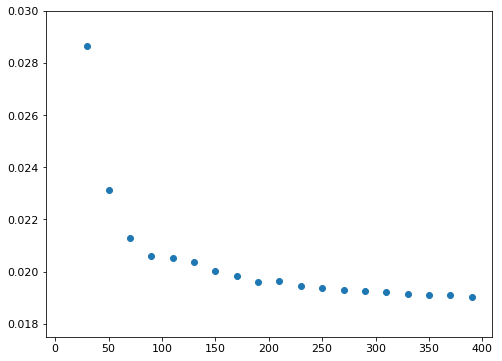

In [85]:
plt.plot(np.arange(10,400,20),sigma_cdm,'o')
plt.ylim(0.0175, 0.03)
plt.show()

In [105]:
teste=np.array([1,2,3,4]).reshape((1,len(teste)))
print np.sum(teste, axis=0)

ValueError: cannot reshape array of size 4 into shape (1,1)

In [103]:
def Fisher_sp(K, Mu, P, P_fid, Rz, F_sky, redshift, Hz, Nz_spec, Nz_phot, Vary, Sigma_z, which, Omg_m, F_nl):
    Omg_m2=np.outer(Omg_m, np.ones((len(redshift))))

    F=np.zeros((len(Vary)/2 +1, len(Vary)/2 +1))
    for p in range(len(Vary)/2 +1):
        for q in range(p,len(Vary)/2 +1):
            integrand3=[]
            for i in range(len(K)):
                integrand2=[]
                k2=[]
                for j in range(i,len(K)):
                    k2.append(K[j])
                    integrand1=[]
                    k1=[]
                    for l in range(j,len(K)):
                        k_lim=min((K[i]+K[j]), max(K))
                        if K[l]<=k_lim:
                            k1.append(K[l])
                            integrand_z=[]
                            integrand_mu=[]
                            B_tot=np.array(B_total(K[i],K[j],K[l], P[:,:,i], P[:,:,j], P[:,:,l], M(K[i], Transf_norm[:,:,i], D_z[:,:], Omg_m2[:,:]), M(K[j], Transf_norm[:,:,j], D_z[:,:], Omg_m2[:,:]), M(K[l], Transf_norm[:,:,l], D_z[:,:], Omg_m2[:,:]), 0.8))
                            B_tot=np.vstack((B_tot, (B_total(K[i],K[j],K[l], P_fid[:,i], P_fid[:,j], P_fid[:,l], M(K[i], Tfid_norm[:,i], D_fid[:], 0.316) , M(K[j], Tfid_norm[:,j], D_fid[:], 0.316), M(K[l], Tfid_norm[:,l], D_fid[:], 0.316), F_nl[0]).reshape((1, len(redshift))))))
                            B_tot=np.vstack((B_tot, (B_total(K[i],K[j],K[l], P_fid[:,i], P_fid[:,j], P_fid[:,l], M(K[i], Tfid_norm[:,i], D_fid[:], 0.316) , M(K[j], Tfid_norm[:,j], D_fid[:], 0.316), M(K[l], Tfid_norm[:,l], D_fid[:], 0.316), F_nl[1]).reshape((1, len(redshift))))))
                            deriv_sss=Derivative(np.concatenate((Vary, F_nl)), B_tot, redshift)
                            deriv_ssp=Derivative(np.concatenate((Vary, F_nl)), B_tot*(exp_z(K[i], Mu[m], Sigma_z, Hz)), redshift)
                            integ=[]
                            if which==0:
                                integ.append(F_sky*((Rz**2.)/Hz)*deriv_sss[p]*deriv_sss[q]*((K[i]*K[j]*K[l])/(4.*(np.pi**3.)*(P_fid[:,i]+(1./Nz_spec))*(P_fid[:,j]+(1./Nz_spec))*(P_fid[:,l]+(1./Nz_spec)))))
                                integ=np.array(integ).reshape((1,len(redshift)))
                            if which==1:
                                integ.append(F_sky*((Rz**2.)/Hz)*deriv_ssp[p]*deriv_ssp[q]*((K[i]*K[j]*K[l])/(4.*(np.pi**3.)*((P_fid[:,i]*(exp_z(K[i], Mu[m], Sigma_z, Hz)**2.))+(1./Nz_phot))*(P_fid[:,j]+(1./Nz_spec))*(P_fid[:,l]+(1./Nz_spec)))))
                                integ=np.array(integ).reshape((1,len(redshift)))
                            if which==2:
                                integ.append(F_sky*((Rz**2.)/Hz)*deriv_sss[p]*deriv_sss[q]*((K[i]*K[j]*K[l])/(4.*(np.pi**3.)*(P_fid[:,i]+(1./Nz_spec))*(P_fid[:,j]+(1./Nz_spec))*(P_fid[:,l]+(1./Nz_spec)))))
                                integ.append(2.*(F_sky*((Rz**2.)/Hz)*deriv_sss[p]*deriv_ssp[q]*((K[i]*K[j]*K[l])/(4.*(np.pi**3.)*((P_fid[:,i]*(exp_z(K[i], Mu[m], Sigma_z, Hz))))*(P_fid[:,j]+(1./Nz_spec))*(P_fid[:,l]+(1./Nz_spec))))))
                                integ.append(F_sky*((Rz**2.)/Hz)*deriv_ssp[p]*deriv_ssp[q]*((K[i]*K[j]*K[l])/(4.*(np.pi**3.)*((P_fid[:,i]*(exp_z(K[i], Mu[m], Sigma_z, Hz)**2.))+(1./Nz_phot))*(P_fid[:,j]+(1./Nz_spec))*(P_fid[:,l]+(1./Nz_spec)))))
                                integrand_z = np.sum(integ, axis=0)
                                integrand_mu.append(integrate.simps(integrand_z, redshift))
                            integrand1.append(integrate.simps(-np.array(integrand_mu), Mu))
                    integrand2.append(integrate.simps(integrand1, k1))
                integrand3.append(integrate.simps(integrand2, k2))
            F[p][q]=integrate.simps(integrand3, K)
            F[q][p]=F[p][q]
            print F
    return F

4
